# Fig 1.09 Hodgkin-Huxley model

In [1]:
using LinearAlgebra
using DifferentialEquations
using Parameters
using LabelledArrays
using Setfield

using Plots
Plots.gr(fmt=:png, lw=2)

Plots.GRBackend()

In [2]:
hill(x, k) = x / (x + k)
hill(x, k, n) = hill(x^n, k^n)
exprel(x) = ifelse(x≈zero(x), one(x), x / expm1(x))

exprel (generic function with 1 method)

In [3]:
"ODE system of HH model"
function hh!(du, u, p, t)
    @unpack E_N, E_K, E_LEAK, G_N_BAR, G_K_BAR, G_LEAK, C_M, I_STIM = p
    @unpack v, m, h, n = u

    mαV = -0.10 * (v + 35)
    mα = exprel(mαV)
    mβ = 4.0 * exp(-(v + 60) / 18.0)

    hα = 0.07 * exp(-(v+60)/20)
    hβ = 1 / (exp(-(v+30)/10) + 1)

    nαV = -0.1 * (v+50)
    nα = 0.1 * exprel(nαV)
    nβ = 0.125 * exp( -(v+60) / 80)

    iNa = G_N_BAR * (v - E_N) * (m^3) * h
    iK  = G_K_BAR * (v - E_K) * (n^4)
    iLeak = G_LEAK * (v - E_LEAK)
    du.v = -(iNa + iK + iLeak + I_STIM) / C_M
    du.m = -(mα + mβ) * m + mα
    du.h = -(hα + hβ) * h + hα
    du.n = -(nα + nβ) * n + nα
    return du
end

hh!

In [4]:
# Parameters for Hodgkin-Huxley model
p = (E_N = 55.0,       # Reversal potential of Na (mV)
     E_K = -72.0,      # Reversal potential of K (mV)
     E_LEAK = -49.0,   # Reversal potential of leaky channels (mV)
     G_N_BAR = 120.0,  # Max. Na channel conductance (mS/cm^2)
     G_K_BAR = 36.0,   # Max. K channel conductance (mS/cm^2)
     G_LEAK = 0.30,    # Max. leak channel conductance (mS/cm^2)
     C_M = 1.0,        # membrane capacitance (uF/cm^2)
     I_STIM = 0.0     # Stimulus current (uA/cm^2)
)

(E_N = 55.0, E_K = -72.0, E_LEAK = -49.0, G_N_BAR = 120.0, G_K_BAR = 36.0, G_LEAK = 0.3, C_M = 1.0, I_STIM = 0.0)

In [5]:
# Events and callbacks
on_i1!(integrator) = integrator.p = @set p.I_STIM = -6.80
off_i1!(integrator) = integrator.p = @set p.I_STIM = 0.0
on_i2!(integrator) = integrator.p = @set p.I_STIM = -6.90

cbs = CallbackSet(PresetTimeCallback([20.0], on_i1!),
              PresetTimeCallback([21.0, 61.0], off_i1!),
              PresetTimeCallback([60.0], on_i2!));

In [6]:
u0 = LVector(v=-59.8977, m=0.0536, h=0.5925, n=0.3192)
tend = 100.0
sol = solve(ODEProblem(hh!, u0, tend, p), callback = cbs);

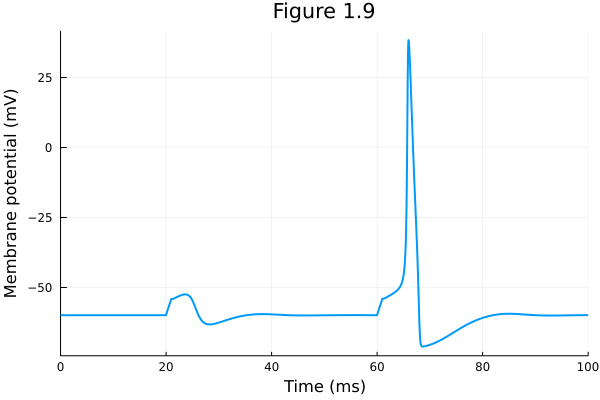

In [7]:
plot(sol, vars=(0, 1),
     ylabel="Membrane potential (mV)", xlabel="Time (ms)", 
     legend=false, title="Figure 1.9")